In [2]:
import numpy as np
import pandas as pd
import re
import joblib
from pathlib import Path

ART_DIR = Path("artifacts_models")

def load_artifact(name):
    path = ART_DIR / name
    if not path.exists():
        raise FileNotFoundError(f"Not found: {path}")
    obj = joblib.load(path)
    print(f"Loaded: {path}")
    return obj

def sanitize_columns(cols):
    cleaned = []
    for c in cols:
        c = str(c).replace("\n","_").replace("\r","_").replace("\t","_")
        c = re.sub(r'[{}\[\]":,\\]', "_", c)
        c = re.sub(r"\s+","_", c)
        c = re.sub(r"_+","_", c).strip("_")
        cleaned.append(c if c else "feat")

    seen = {}
    out = []
    for c in cleaned:
        if c not in seen:
            seen[c] = 0
            out.append(c)
        else:
            seen[c] += 1
            out.append(f"{c}__{seen[c]}")
    return out

def preprocess_like_train(df, target_col="TARGET"):
    """
    Mimic prepare_X_y_from_fs_df:
      - drop TARGET if exists
      - fill cat with Unknown, num with median (computed from df itself here)
      - get_dummies(drop_first=True)
      - sanitize columns
      - inf -> nan -> median
    """
    X = df.copy()
    if target_col in X.columns:
        X = X.drop(columns=[target_col], errors="ignore")

    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(exclude="object").columns.tolist()

    X[cat_cols] = X[cat_cols].fillna("Unknown")
    for c in num_cols:
        X[c] = X[c].fillna(X[c].median())

    X = pd.get_dummies(X, drop_first=True)

    for c in X.columns:
        if X[c].dtype == bool:
            X[c] = X[c].astype(np.int8)

    X.columns = sanitize_columns(X.columns)

    X = X.replace([np.inf, -np.inf], np.nan)
    for c in X.columns:
        if X[c].isna().any():
            X[c] = X[c].fillna(X[c].median())

    return X

def align_to_feature_names(X, feature_names):
    """
    Ensure X has exactly feature_names in same order.
    Missing columns -> 0
    Extra columns -> dropped
    """
    X = X.copy()
    missing = [c for c in feature_names if c not in X.columns]
    if missing:
        for c in missing:
            X[c] = 0

    X = X[feature_names]
    return X


In [5]:
# load final train feature list used to train models
data_final = load_artifact("data_final.pkl")
final_feature_names = data_final["X_final"].columns.tolist()
print("Final feature count:", len(final_feature_names))

# load test features
fs_test_df = pd.read_csv("fs_df_test.csv")

# must have ID
if "SK_ID_CURR" not in fs_test_df.columns:
    raise ValueError("fs_test_df must include SK_ID_CURR column for submission index.")

test_ids = fs_test_df["SK_ID_CURR"].copy()

# preprocess test like train
X_test_all = preprocess_like_train(fs_test_df, target_col="TARGET")

# align to final feature space
X_test = align_to_feature_names(X_test_all, final_feature_names)
print("X_test shape aligned:", X_test.shape)

save_path = ART_DIR / "X_test_aligned.pkl"
joblib.dump({"SK_ID_CURR": test_ids, "X_test": X_test}, save_path)
print("Saved:", save_path)


Loaded: artifacts_models\data_final.pkl
Final feature count: 40
X_test shape aligned: (48744, 40)
Saved: artifacts_models\X_test_aligned.pkl


In [8]:
import glob
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb

ART_DIR = Path("artifacts_models")
out_dir = ART_DIR / "submissions"
out_dir.mkdir(exist_ok=True)

# Load aligned test pack
test_pack = joblib.load(ART_DIR / "X_test_aligned.pkl")
test_ids = test_pack["SK_ID_CURR"]
X_test = test_pack["X_test"]

# Load sample_submission (use your path)
sample_sub = pd.read_csv("home-credit-default-risk/sample_submission.csv")
if "SK_ID_CURR" not in sample_sub.columns or "TARGET" not in sample_sub.columns:
    raise ValueError("sample_submission.csv must have columns: SK_ID_CURR, TARGET")

def align_to_feature_names(X, feat_names):
    return X.reindex(columns=feat_names, fill_value=0)

def is_model_bundle(bundle: dict):
    return isinstance(bundle, dict) and ("model" in bundle) and ("feature_names" in bundle)

# find all model_*.pkl but SKIP registry/champion/data/info
model_paths = sorted(glob.glob(str(ART_DIR / "model_*.pkl")))
if not model_paths:
    raise FileNotFoundError("No model_*.pkl found in artifacts_models/")

created = []
skipped = []

for mp in model_paths:
    bundle = joblib.load(mp)
    name = Path(mp).name

    # ✅ skip non-model bundles like model_registry.pkl
    if not is_model_bundle(bundle):
        skipped.append(name)
        continue

    algo = bundle.get("algo", Path(mp).stem.replace("model_", ""))
    model = bundle["model"]
    feat_names = bundle["feature_names"]

    X_t = align_to_feature_names(X_test, feat_names)

    # Predict
    if hasattr(model, "predict_proba"):
        pred = model.predict_proba(X_t)[:, 1]
    elif isinstance(model, xgb.Booster):
        dtest = xgb.DMatrix(X_t)
        best_iter = getattr(model, "best_iteration", None)
        if best_iter is not None:
            pred = model.predict(dtest, iteration_range=(0, best_iter + 1))
        else:
            pred = model.predict(dtest)
    else:
        raise TypeError(f"Unsupported model type in {name}: {type(model)}")

    pred = np.clip(pred.astype(float), 1e-6, 1 - 1e-6)

    # Build submission
    sub = sample_sub.copy()
    sub["SK_ID_CURR"] = test_ids.values
    sub["TARGET"] = pred

    out_path = out_dir / f"submission_{algo}.csv"
    sub.to_csv(out_path, index=False)
    created.append(str(out_path))
    print("Created:", out_path)

# Save registry
joblib.dump({"submission_files": created, "skipped_files": skipped}, ART_DIR / "submissions_registry.pkl")
print("\nSaved:", ART_DIR / "submissions_registry.pkl")
print("Skipped:", skipped)


Created: artifacts_models\submissions\submission_ada.csv
Created: artifacts_models\submissions\submission_gnb.csv
Created: artifacts_models\submissions\submission_lgbm_base.csv
Created: artifacts_models\submissions\submission_lgbm_opt.csv
Created: artifacts_models\submissions\submission_logreg.csv
Created: artifacts_models\submissions\submission_xgb_base_native.csv

Saved: artifacts_models\submissions_registry.pkl
Skipped: ['model_registry.pkl']


In [9]:
import zipfile
from pathlib import Path

zip_path = Path("submissions.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for p in Path("artifacts_models/submissions").glob("*.csv"):
        z.write(p, arcname=p.name)

zip_path


WindowsPath('submissions.zip')

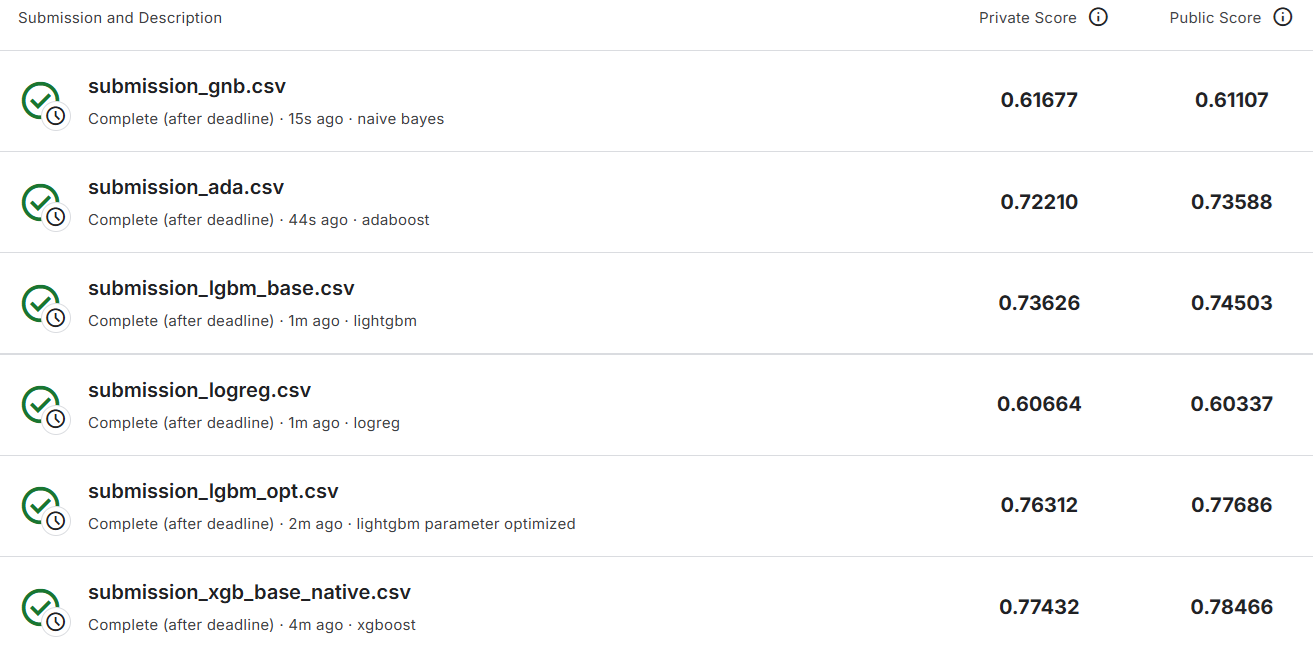

In [11]:
from IPython.display import Image, display

display(Image(filename="kaggle_results.png"))
